<h1>Preliminaries</h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t
import seaborn as sns
import sklearn.model_selection
import sklearn.linear_model
np.random.seed(0)

<h1>1. Constructing confidence interval via Central Limit Theorem</h1>

<p>Recap:<br>
CLT says, in many situations, when independent random variables are summed up, their properly normalized sum tends toward a normal distribution even if the original variables themselves are not normally distributed. This is a key concept in probability theory because it implies that probabilistic and statistical methods that work for normal distributions can be applicable to many problems involving other types of distributions.</p>

In [2]:
# From the PTSD paper cited in Slide 26 (A Blood Test Might One Day Mass Screen Military Personnel
# for Post-Traumatic Stress Disorder (PTSD)), there were 52 test cases 42 of which were correct

n = 52 # total number of the test set sample
c = 42 # predicted correctly 42 cases

# Create array of zeros, size n
rawdata = np.zeros(n)

# Set first c elements to 1
rawdata[range(c)] = 1

# Create pandas data frame
data = pd.DataFrame({"Match": rawdata})
data.head(2)

,Match
0,1.0
1,1.0


First, we'll build the confidence interval assuming a normal variable

In [3]:
## Using central limit theorem, compute confidence interval

stderr = np.std(data.Match) / np.sqrt(len(data.Match))
print("Stderr: %.3f" % stderr)

# Area under a standard normal from -1.96 to 1.96 is about 95% (3 for 99.9% probability)
critval = 1.96 # critical value

# Confidence interval
norm_ci = [(data.Match.mean() - critval*stderr).round(3), 
           (data.Match.mean() + critval*stderr).round(3)]

print("Norm ci:",norm_ci)

# Stderr: 0.055
# Norm ci: [0.7, 0.916]

Stderr: 0.055
Norm ci: [0.701, 0.915]


[t_test](https://en.wikipedia.org/wiki/Student%27s_t-test)

[t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution)

If we take a sample of $n$ observations from a normal distribution, then the t-distribution with $n − 1$ degrees of freedom can be defined as the distribution of the location of the sample mean relative to the true mean, divided by the sample standard deviation, after multiplying by the standardizing term $\sqrt {n}$. In this way, the t-distribution can be used to construct a confidence interval for the true mean.

What if we use a t-test?

$$ EBM =  (t_{1-\alpha/2, n-1}) (\dfrac{s}{\sqrt{n}}) $$

EBM: Error bound for a population mean

$s$: The population $\sigma$ is not known, we estimate $\sigma$ with $s$ which is the sample's standard deviation. 

Confidence interval for $(1-\alpha)100\%$ confidence level is $\bar{x} \pm  EBM$

The t distribution is available for us to use in the [scipy.stats.t package](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html).

You can see different implemented probability distributions [Statistical functions.](https://docs.scipy.org/doc/scipy/reference/stats.html)

In [4]:
# Get the critical values for t at an alpha = 0.05/2 (i.e., 5% divided by 2), and 52-1 = 51 dof.
alpha = (5/100)
crit_val = 1-(alpha/2)

# Degrees of freedom (dof) of an estimate is the number of independent
# pieces of information that went into calculating the estimate.
dof = n-1
# the precise shape of the t distribution depends on dof, which is related to the sample size.

# ppf: percent point function (inverse of cdf — percentiles).
# It returns the value x of the variable that has a given cumulative distribution probability (cdf).
# Thus, given the cdf(x) of a x value, ppf returns the value x itself, therefore, operating as the inverse of cdf.
t_value = t.ppf(crit_val, df=dof) # 1st arg: critical value; 2nd arg: dof

stderr = np.std(data.Match) / np.sqrt(len(data.Match))

t_ci = data.Match.mean() + t_value * stderr * np.array([-1, 1])
print('The t-based confidence interval is equal to {}'.format(t_ci.round(3)))

The t-based confidence interval is equal to [0.698 0.917]


The t-based critical value equals to 2.01 which is a little bit different from 1.96. The difference is 0.05 that is about 2% off from the normal approximation. Depending on your application 2% off may or may not be significant. If it is not, you can use the normal approximation.

<h1>2. Constructing confidence interval via bootstrapping</h1>

In [5]:
# From PTSD paper, there were 52 test cases, 42 of which were correct
n = 52
c = 42

# Create array of zeros, size n
rawdata = np.zeros(n)

# Set first c elements to 1
rawdata[range(c)] = 1

# Create pandas data frame
data = pd.DataFrame({"Match": rawdata})
data.head()

,Match
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


In [6]:
# Compute 10000 bootstrap datasets, compute means in each

def createBootstrapMeans(data, numboot=10000):
    n = len(data)
    boot_means = np.zeros(numboot)
    for i in range(numboot):
        d = data.sample(n, replace=True)
        boot_means[i] = d.mean()
    return boot_means

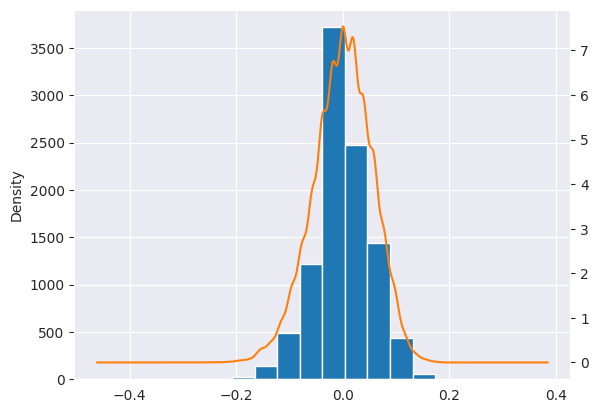

Boot Confidence Interval: [0.712, 0.923]


In [7]:
# even though we are not using seaborn we can style the plots with it
sns.set_style("darkgrid") 

# Create a dataframe
bm = pd.DataFrame(data=createBootstrapMeans(data)-data.Match.mean(), columns=['samples'])

# Plot histogram and KDE
ax = bm.samples.plot(kind='hist')
bm.samples.plot(kind='kde', ax=ax, secondary_y=True)
plt.show()

# Bootstrap with CL of 95%
boot_CL = 95/100 
p_1 = (1-boot_CL)/2
p_2 = 1-p_1
boot_quant = np.quantile(bm, [p_1, p_2])
# print('boot_quant:',boot_quant)
# boot_quant = np.quantile(bm, [p_1, p_2]) gives -0.12 and 0.1. This means we are 95%
# confident that the calculated statistic for Boot is somewhere between 0.12 lower than
# the sample's up to 0.1 higher than the sample's. And from this we deduce that the
# sample's statistic is between 0.12 lower than the population's up to 0.1 higher than
# the population's:  Population-0.12 < Sample < Population+0.1
# We are eventually interested in getting a CI that embraces the population's. Rearranging
# the above inequality yields: Sample-0.1 < Population < Sample+0.12
# We are 95% confident that the population's statistic is somewhere between 0.1 lower than
# the sample's up to 0.12 higher than the sample's.

# Compute confidence interval
boot_ci = [(data.Match.mean() - boot_quant[1]).round(3), 
           (data.Match.mean() - boot_quant[0]).round(3)]
print("Boot Confidence Interval:",boot_ci)

# In the previous cells we saw:
# Norm CI: [0.701, 0.915]
# t    CI: [0.698 0.917]

<h1> 3. Bootstrapping of regression model </h1>

<h2> 3.1. Making a model </h2>

In [8]:
# Data: 1000 births from North Carolina
# https://www.openintro.org/stat/data/?data=nc
# We are interested in the link between 
# Weeks: gestation time (length of the pregnancy in weeks) 
# Weight: Birth weight im pounds
D = pd.read_csv("nc.csv")
D.head()

,fage,mage,mature,weeks,premie,visits,marital,gained,weight,lowbirthweight,gender,habit,whitemom
0,NaN,13,younger mom,39.0,full term,10.0,married,38.0,7.63,not low,male,nonsmoker,not white
1,NaN,14,younger mom,42.0,full term,15.0,married,20.0,7.88,not low,male,nonsmoker,not white
2,19.0,15,younger mom,37.0,full term,11.0,married,38.0,6.63,not low,female,nonsmoker,white
3,21.0,15,younger mom,41.0,full term,6.0,married,34.0,8.00,not low,male,nonsmoker,white
4,NaN,15,younger mom,39.0,full term,9.0,married,27.0,6.38,not low,female,nonsmoker,not white


In [9]:
# Check for missing data and exclude observations
print("Number of NaN:",sum(np.isnan(D.weeks)))
D = D[~np.isnan(D.weeks)]

Number of NaN: 2


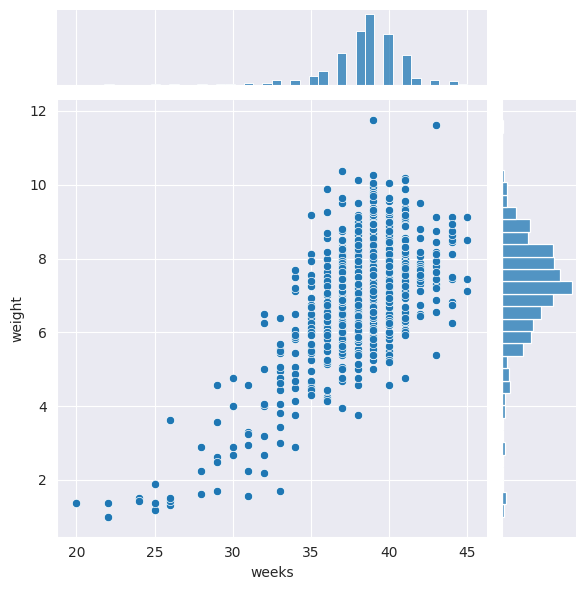

In [10]:
# Make a Joint plot between weeks and weight
sns.jointplot(data=D, x='weeks', y='weight')

# # You can also plot the joint probability distribution
# kdeplot = sns.jointplot(data=D, x='weeks', y='weight', kind='kde', fill=True, cbar=True)
# plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
# # get the current positions of the joint ax and the ax for the marginal x
# pos_joint_ax = kdeplot.ax_joint.get_position()
# pos_marg_x_ax = kdeplot.ax_marg_x.get_position()
# # reposition the joint ax so it has the same width as the marginal x ax
# kdeplot.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
# # reposition the colorbar using new x positions and y positions of the joint ax
# kdeplot.fig.axes[-1].set_position([.83, pos_joint_ax.y0, .07, pos_joint_ax.height])

plt.show()

In [11]:
# Train a model on the training set
regr = sklearn.linear_model.LinearRegression()

X_fit = np.c_[D.weeks, D.weeks**2, D.weeks**3] # adding transformed versions of x to X to better fit the relationship
regr.fit(X_fit, D.weight)
regr.coef_

array([-5.21866875e+00,  1.78832738e-01, -1.85596626e-03])

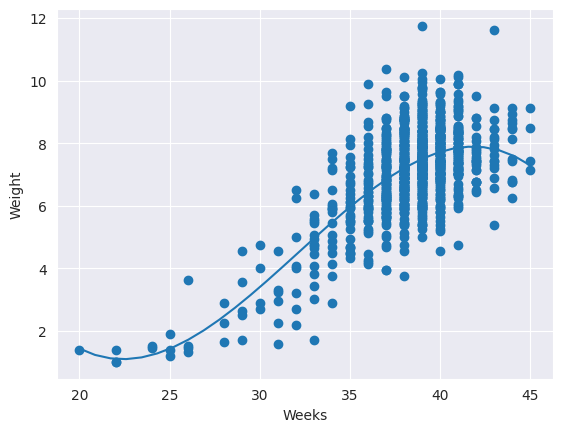

In [12]:
# Plot the Fit of model 
plt.scatter(D.weeks, D.weight)

p_weeks = np.linspace(D.weeks.min(), D.weeks.max(), 30) # create new vector

X_pred = np.c_[p_weeks, p_weeks**2, p_weeks**3]

p_weight = regr.predict(X_pred)

plt.plot(p_weeks, p_weight)
plt.xlabel("Weeks")
plt.ylabel("Weight")
plt.show()

<h2> 3.2. Bootstrap the model parameters </h2>

In [13]:
# Write a Bootstrap function that records the fitted models 
def BootstrapCoef(data, numboot=1000):
    n = len(data)
    theta = np.zeros((numboot,3))    
    for i in range(numboot):
        d = data.sample(n, replace=True)
        X_fit = np.c_[d.weeks,d.weeks**2,d.weeks**3]
        regr.fit(X_fit,d.weight)
        theta[i,:]=regr.coef_
    return theta

In [14]:
# Get 1000 Bootstrap fits
thetaBS = BootstrapCoef(D)
print(thetaBS.shape)
thetaBS

(1000, 3)


array([[-5.08561068e+00,  1.75309065e-01, -1.82490474e-03],
       [-6.49713727e+00,  2.17645206e-01, -2.24009841e-03],
       [-5.85704373e+00,  1.98209716e-01, -2.04922007e-03],
       ...,
       [-4.39197969e+00,  1.51518868e-01, -1.56551476e-03],
       [-4.84220682e+00,  1.68968512e-01, -1.77711026e-03],
       [-4.91776054e+00,  1.69693545e-01, -1.76569533e-03]])

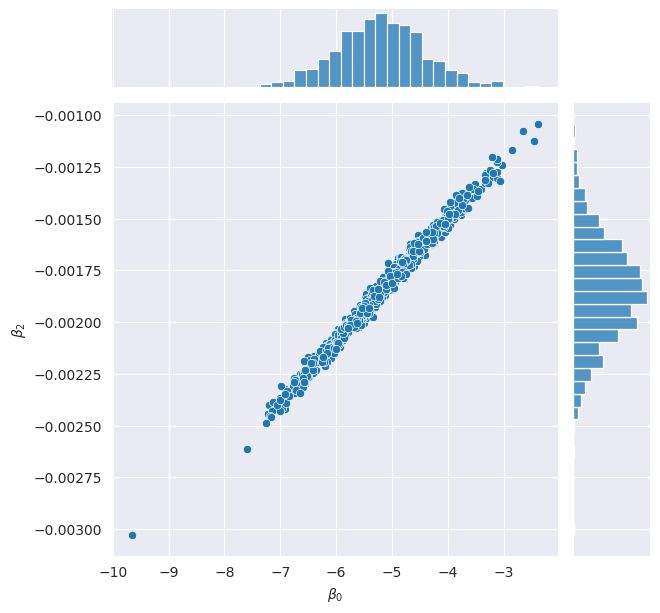

In [15]:
# Make a joint plot of two parameters 
sns.jointplot(x=thetaBS[:,0],y=thetaBS[:,2])
plt.xlabel(r"$\beta_{0}$")
plt.ylabel(r"$\beta_{2}$")
plt.show()

<h2>3.3. Bootstrap the model prediction</h2>

In [16]:
# Write a Bootstrap function that records the fitted models 
def BootstrapPred(data, xp, numboot=1000):
    n = len(data)
    X_pred = np.c_[xp,xp**2,xp**3]
    y_pred = np.zeros((numboot,X_pred.shape[0]))
    for i in range(numboot):
        d = data.sample(n, replace=True)
        X_fit = np.c_[d.weeks,d.weeks**2,d.weeks**3]
        regr.fit(X_fit,d.weight)
        y_pred[i,:]=regr.predict(X_pred)
    return y_pred

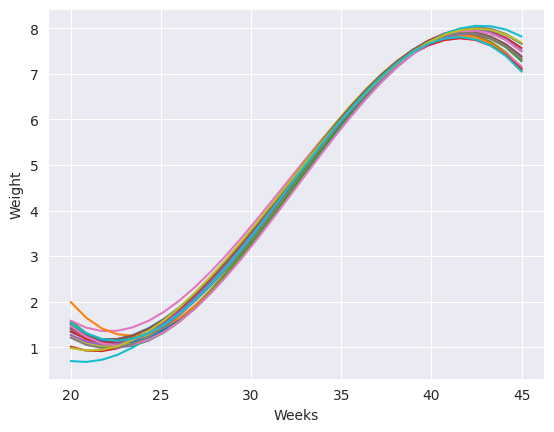

In [17]:
# Plot 20 of the bootstrapped predictions 
yhat_s    = p_weight
yhat_boot = BootstrapPred(D, p_weeks)

for i in range(20):
    plt.plot(p_weeks, yhat_boot[i,:])

plt.xlabel("Weeks")
plt.ylabel("Weight")
plt.show()

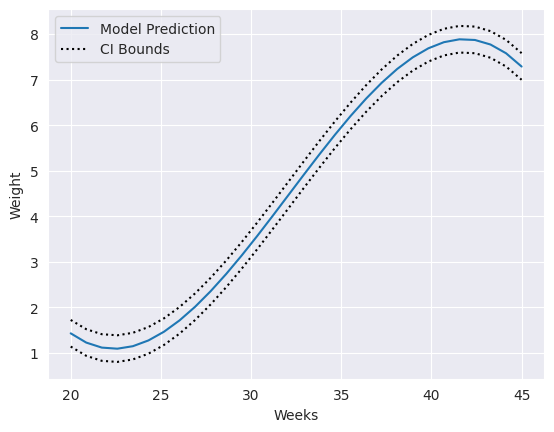

In [18]:
# Calculate upper and lower confidence bounds for prediction by bootstrapping

boot_CL = 95/100 
p_1 = (1-boot_CL)/2
p_2 = 1-p_1

boot_quant = np.quantile(yhat_boot-yhat_s, [p_1, p_2])

boot_ci = [yhat_s - boot_quant[0], 
           yhat_s - boot_quant[1]]

# Plot prediction
plt.plot(p_weeks, yhat_s, label="Model Prediction")

# plot CI
plt.plot(p_weeks, boot_ci[0],'k:', label="CI Bounds")
plt.plot(p_weeks, boot_ci[1],'k:')
plt.xlabel("Weeks")
plt.ylabel("Weight")
plt.legend()
plt.show()